 ## PROJECT CODE                                                            
   ## M.USMAN
   ## 22P-9071
   ## BCS-6A

[INFO] Loaded metadata: (72, 2)
[INFO] Images loaded and flattened: (72, 4096)


C:\Users\usm76\AppData\Local\Temp\ipykernel_17244\1910377707.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


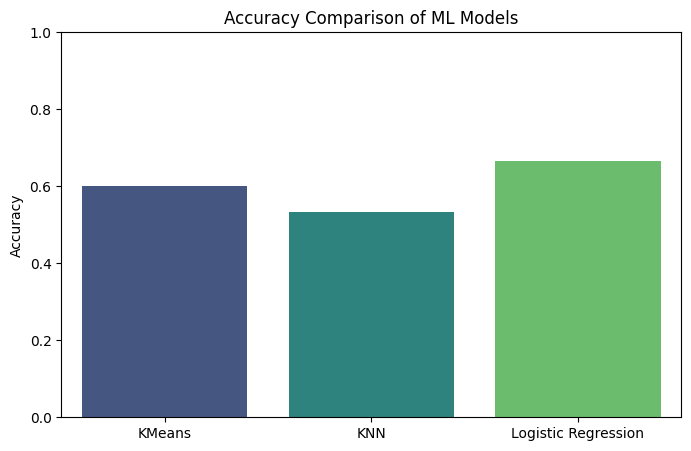

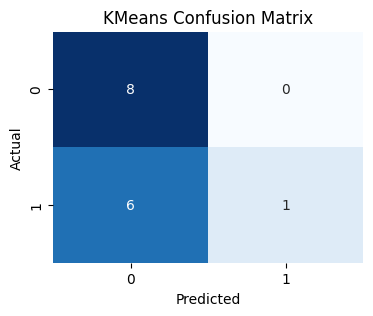

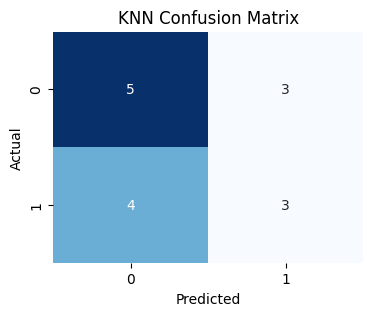

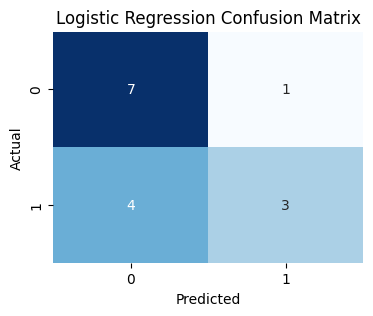


=== KMeans Report ===
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.14      0.25         7

    accuracy                           0.60        15
   macro avg       0.79      0.57      0.49        15
weighted avg       0.77      0.60      0.50        15


=== KNN Report ===
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.50      0.43      0.46         7

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.52        15
weighted avg       0.53      0.53      0.53        15


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.75      0.43      0.55         7

    accuracy                           0.67        15
   macro avg       0.69      0.65      0.64      

In [5]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

# ---------------------- CONFIG ----------------------
IMAGE_DIR = 'spirals'           # Folder containing images
CSV_PATH = 'metadata.csv'        # Metadata file path
IMAGE_SIZE = (64, 64)            # Image resize target
# ----------------------------------------------------

# Step 1: Load metadata
df = pd.read_csv(CSV_PATH)
print("[INFO] Loaded metadata:", df.shape)

# Step 2: Load and process images
def load_images(df, img_folder, size=(64, 64)):
    X = []
    y = []
    updrs = []

    for _, row in df.iterrows():
        path = os.path.join(img_folder, row['filename'])
        if not os.path.exists(path): continue

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        img_flat = img.flatten()

        X.append(img_flat)
        y.append(row['label'])  # 0 = Healthy, 1 = Parkinson's
        updrs.append(row.get('updrs_score', np.nan))  # Optional

    return np.array(X), np.array(y), np.array(updrs)

X, y, updrs = load_images(df, IMAGE_DIR)
print("[INFO] Images loaded and flattened:", X.shape)

# Step 3: Train/Test split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Train models and store predictions
results = {}

# --- KMeans (Unsupervised) ---
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_test)
results['KMeans'] = {
    "y_pred": kmeans_labels,
    "accuracy": accuracy_score(y_test, kmeans_labels),
    "report": classification_report(y_test, kmeans_labels, output_dict=True),
    "cm": confusion_matrix(y_test, kmeans_labels)
}

# --- K-Nearest Neighbors ---
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
results['KNN'] = {
    "y_pred": y_pred_knn,
    "accuracy": accuracy_score(y_test, y_pred_knn),
    "report": classification_report(y_test, y_pred_knn, output_dict=True),
    "cm": confusion_matrix(y_test, y_pred_knn)
}

# --- Logistic Regression ---
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
results['Logistic Regression'] = {
    "y_pred": y_pred_logreg,
    "accuracy": accuracy_score(y_test, y_pred_logreg),
    "report": classification_report(y_test, y_pred_logreg, output_dict=True),
    "cm": confusion_matrix(y_test, y_pred_logreg)
}

# Step 5: Linear Regression (optional for UPDRS)
if not np.isnan(updrs).all():
    updrs = updrs[~np.isnan(updrs)]
    X_reg = X[:len(updrs)]
    Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, updrs, test_size=0.2, random_state=42)

    lr = LinearRegression()
    lr.fit(Xr_train, yr_train)
    yp = lr.predict(Xr_test)

    print("\n[ Linear Regression on UPDRS ]")
    print("MSE:", mean_squared_error(yr_test, yp))
    print("R² Score:", r2_score(yr_test, yp))

# Step 6: Accuracy bar plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=list(results.keys()),
    y=[results[m]["accuracy"] for m in results],
    palette="viridis"
)
plt.title("Accuracy Comparison of ML Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Step 7: Confusion matrix plots
def plot_confusion(cm, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

for model_name, model_data in results.items():
    plot_confusion(model_data["cm"], f"{model_name} Confusion Matrix")

# Optional: Print classification reports in text
for model_name, model_data in results.items():
    print(f"\n=== {model_name} Report ===")
    print(classification_report(y_test, model_data["y_pred"]))
